<B>Load the llama3 token from .env</B>

In [1]:
# huggingface-cli login   >>> we can use this onetime in the terminal 

# or throw this 
# import os
# from dotenv import load_dotenv

# load_dotenv()
# api_token = os.getenv("LLAMA_API_TOKEN")

In [2]:
# Check the GPU availability    
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
NVIDIA GeForce RTX 3060 Laptop GPU


In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

def initialize_llama3(model_id="meta-llama/Llama-3.2-3B-Instruct", use_4bit=True):
    """
    Initialize LLaMA 3 model from Hugging Face using Transformers.
    
    Args:
        model_id (str): Hugging Face model ID 
        use_4bit (bool): Whether to load the model using 4-bit quantization for memory efficiency

    Returns:
        tuple: (model, tokenizer, text-generation pipeline)
    """
    print(f"Loading model: {model_id}")

    # Load the tokenizer (no need to manually pass token)
    tokenizer = AutoTokenizer.from_pretrained(model_id)

    # Load the model
    if use_4bit:
        # Optional: requires `bitsandbytes` installed
        quantization_config = {
            "load_in_4bit": True,
            "bnb_4bit_compute_dtype": torch.bfloat16,
            "bnb_4bit_quant_type": "nf4",
            "bnb_4bit_use_double_quant": True,
        }
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            device_map="auto",
            torch_dtype=torch.bfloat16,
            quantization_config=quantization_config,
        )
    else:
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            device_map="auto",
            torch_dtype=torch.bfloat16
        )

    # Create a text-generation pipeline
    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=512,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        return_full_text=False
    )

    return model, tokenizer, pipe

# Example usage
model, tokenizer, llama3_pipe = initialize_llama3()

Loading model: meta-llama/Llama-3.2-3B-Instruct


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [4]:
def query_llm(prompt, max_new_tokens=500, temperature=0.7):
    """
    Send a prompt to LLaMA 3 and get a response.

    Args:
        prompt (str): The prompt to send to the model
        max_new_tokens (int): Maximum length of the response
        temperature (float): Controls randomness (0-1)

    Returns:
        str: The model's response
    """
    try:
        # Format the prompt using LLaMA 3's chat template
        messages = [{"role": "user", "content": prompt}]
        formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False)

        # Generate the response
        result = llama3_pipe(
            formatted_prompt,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True,
            top_p=0.9,
        )

        return result[0]['generated_text']
    except Exception as e:
        print(f"Error querying LLaMA 3: {e}")
        return None
def calculate_response_metrics(response):
    """
    Calculate basic metrics about the response.

    Args:
        response (str): The model's response

    Returns:
        dict: Dictionary of metrics
    """
    metrics = {
        "word_count": len(response.split()),
        "char_count": len(response),
        "sentence_count": response.count('. ') + response.count('! ') + response.count('? ')
    }
    return metrics


In [5]:
# Test the LLaMA 3 setup
test_prompt = "What is prompt engineering?"
response = query_llm(test_prompt)

# Print the model's response
print("LLaMA 3 Response:")
print(response)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


LLaMA 3 Response:
assistant

Prompt engineering is a subfield of natural language processing (NLP) that focuses on designing and optimizing the input prompts used to elicit specific responses from language models, such as chatbots, virtual assistants, and other AI systems. The goal of prompt engineering is to craft high-quality prompts that elicit the desired output from the model, taking into account its strengths, weaknesses, and limitations.

Prompt engineering involves several key aspects:

1. **Prompt design**: Creating well-structured and clear prompts that accurately convey the desired intent, context, and requirements.
2. **Prompt optimization**: Refining the prompt to achieve the desired outcome, such as improving response accuracy, relevance, and coherence.
3. **Prompt tuning**: Adjusting the prompt to accommodate the model's limitations, biases, and idiosyncrasies.
4. **Prompt evaluation**: Assessing the effectiveness of the prompt in eliciting the desired response, and maki

In [6]:
# Define a set of tasks for comparison
tasks = [
    "Classify the following review as positive or negative: 'The service was terrible but the food was amazing.'",
    "Identify the emotion in this sentence: 'I can't believe I failed the exam after studying so hard.'",
    "Categorize this news headline as politics, sports, or entertainment: 'New trade agreement signed between countries.'",
    "Determine if this statement is a fact or opinion: 'Coffee is the best beverage for morning productivity.'"
]
few_shot_examples = {
    "sentiment": [
        {"example": "The movie was fantastic and I enjoyed every minute.", "label": "Positive"},
        {"example": "The hotel room was dirty and the staff was rude.", "label": "Negative"},
        {"example": "While the price was high, the quality was worth it.", "label": "Positive"}
    ],
    "emotion": [
        {"example": "I just won the lottery!", "label": "Joy"},
        {"example": "My dog passed away yesterday.", "label": "Sadness"},
        {"example": "They didn't invite me to the party.", "label": "Disappointment"}
    ],
    "categorization": [
        {"example": "Local election results surprise analysts.", "label": "Politics"},
        {"example": "New movie breaks box office records.", "label": "Entertainment"},
        {"example": "Team wins championship for the third time.", "label": "Sports"}
    ],
    "fact_opinion": [
        {"example": "The Earth orbits around the Sun.", "label": "Fact"},
        {"example": "Summer is the best season of the year.", "label": "Opinion"},
        {"example": "Chocolate contains caffeine.", "label": "Fact"}
    ]
}

In [7]:
def zero_shot_prompt(task):
    """
    Perform zero-shot prompting for a given task.

    Args:
        task (str): The task to perform

    Returns:
        str: The model's response
    """
    prompt = task
    return query_llm(prompt)
# Initialize results list
zero_shot_results = []

# Loop over all tasks and collect results
for task in tasks:
    response = zero_shot_prompt(task)
    zero_shot_results.append({
        "task": task,
        "response": response,
        "metrics": calculate_response_metrics(response)
    })

    # Print the result
    print(f"Task: {task}")
    print(f"Response: {response}\n")


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Task: Classify the following review as positive or negative: 'The service was terrible but the food was amazing.'
Response: assistant

This review is mixed, but leaning towards being positive. Although the reviewer mentions that the "service was terrible", they also state that the "food was amazing", which suggests that the positive aspect of their experience outweighed the negative one.



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Task: Identify the emotion in this sentence: 'I can't believe I failed the exam after studying so hard.'
Response: assistant

The emotion expressed in the sentence is disappointment.



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Task: Categorize this news headline as politics, sports, or entertainment: 'New trade agreement signed between countries.'
Response: assistant

This news headline can be categorized as 'politics'.

Task: Determine if this statement is a fact or opinion: 'Coffee is the best beverage for morning productivity.'
Response: assistant

This statement is an opinion. The reason is that "best" is a subjective term, and people may have different preferences when it comes to their morning beverage. While some people may agree that coffee is the best beverage for morning productivity, others may prefer tea, juice, or other options.

Additionally, the statement is not supported by objective evidence, and there is no scientific proof that coffee is the only or even the best beverage for morning productivity. It's a matter of personal taste and individual experiences.

Therefore, it's an opinion, not a fact.



In [8]:
def few_shot_prompt(task, examples):
    """
    Perform few-shot prompting for a given task.

    Args:
        task (str): The task to perform
        examples (list): List of example dictionaries with 'example' and 'label' keys

    Returns:
        str: The model's response
    """
    # Construct the prompt with examples
    prompt = "Here are some examples:\n\n"

    for example in examples:
        prompt += f"Input: {example['example']}\nOutput: {example['label']}\n\n"

    # Extract the actual input text from the task
    if ': ' in task:
        input_text = task.split(': ', 1)[1]
    else:
        input_text = task

    prompt += f"Input: {input_text}\nOutput:"
    return query_llm(prompt)
# Map each task index to its corresponding example category
task_to_examples = {
    0: "sentiment",
    1: "emotion",
    2: "categorization",
    3: "fact_opinion"
}
# Store results
few_shot_results = []

for i, task in enumerate(tasks):
    example_type = task_to_examples[i]
    examples = few_shot_examples[example_type]

    response = few_shot_prompt(task, examples)
    few_shot_results.append({
        "task": task,
        "response": response,
        "metrics": calculate_response_metrics(response),
        "example_type": example_type
    })

    # Print output
    print(f"Task: {task}")
    print(f"Examples used: {example_type}")


    print(f"Response: {response}\n")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Task: Classify the following review as positive or negative: 'The service was terrible but the food was amazing.'
Examples used: sentiment
Response: assistant

Negative

Explanation: Although the service was terrible, the positive aspect (the food) outweighs the negative, so the overall sentiment is still considered positive.



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Task: Identify the emotion in this sentence: 'I can't believe I failed the exam after studying so hard.'
Examples used: emotion
Response: assistant

Anger



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Task: Categorize this news headline as politics, sports, or entertainment: 'New trade agreement signed between countries.'
Examples used: categorization
Response: assistant

Politics

Task: Determine if this statement is a fact or opinion: 'Coffee is the best beverage for morning productivity.'
Examples used: fact_opinion
Response: assistant

Opinion



In [9]:
import pandas as pd 

# Create a comparison dataframe
comparison_data = []

for i in range(len(tasks)):
    comparison_data.append({
        "Task": tasks[i],
        "Zero-shot Response": zero_shot_results[i]["response"],
        "Few-shot Response": few_shot_results[i]["response"]
    })

comparison_df = pd.DataFrame(comparison_data)

# Display the comparison
print(comparison_df)
# Save the comparison to a CSV file
comparison_df.to_csv("zero_shot_vs_few_shot_comparison.csv", index=False)


                                                Task  \
0  Classify the following review as positive or n...   
1  Identify the emotion in this sentence: 'I can'...   
2  Categorize this news headline as politics, spo...   
3  Determine if this statement is a fact or opini...   

                                  Zero-shot Response  \
0  assistant\n\nThis review is mixed, but leaning...   
1  assistant\n\nThe emotion expressed in the sent...   
2  assistant\n\nThis news headline can be categor...   
3  assistant\n\nThis statement is an opinion. The...   

                                   Few-shot Response  
0  assistant\n\nNegative\n\nExplanation: Although...  
1                                 assistant\n\nAnger  
2                              assistant\n\nPolitics  
3                               assistant\n\nOpinion  


In [10]:
reasoning_problems = [
    ["If a shirt originally costs $100 and is on sale for 25% off, and then an additional 10% is taken off the discounted price, what is the final price of the shirt?"],
    ["A train travels at a speed of 60 miles per hour. How far will it travel in 2.5 hours?"],
    ["If it takes 5 machines 5 minutes to make 5 widgets, how long would it take 100 machines to make 100 widgets?"],
    ["A bat and a ball cost $1.10 in total. The bat costs $1.00 more than the ball. How much does the ball cost?"]
]

def standard_prompt(problem):
    """
    Perform standard prompting for a reasoning problem.

    Args:
        problem (str): The reasoning problem

    Returns:
        str: The model's response
    """
    prompt = f"Answer the following question: {problem}"
    return query_llm(prompt)

# Test standard prompting on our reasoning problems
standard_results = []
for problem in reasoning_problems:
    response = standard_prompt(problem[0])  # Get the response from the model
    standard_results.append({
        "problem": problem[0],
        "response": response
    })
    print(f"Problem: {problem[0]}")
    print(f"Response: {response}\n")



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Problem: If a shirt originally costs $100 and is on sale for 25% off, and then an additional 10% is taken off the discounted price, what is the final price of the shirt?
Response: assistant

To find the final price of the shirt, we need to calculate the discount in two steps:

1. Calculate the 25% discount from the original price:
$100 * 0.25 = $25 (discount amount)
$100 - $25 = $75 (discounted price)

2. Calculate the additional 10% discount from the discounted price:
$75 * 0.10 = $7.50 (discount amount)
$75 - $7.50 = $67.50 (final price)

The final price of the shirt is $67.50.



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Problem: A train travels at a speed of 60 miles per hour. How far will it travel in 2.5 hours?
Response: assistant

To find the distance the train will travel, you need to multiply its speed by the time it travels.

Distance = Speed * Time
Distance = 60 miles/hour * 2.5 hours
Distance = 150 miles

The train will travel 150 miles in 2.5 hours.



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Problem: If it takes 5 machines 5 minutes to make 5 widgets, how long would it take 100 machines to make 100 widgets?
Response: assistant

To solve this problem, we can use the concept of proportionality. Since 5 machines can make 5 widgets in 5 minutes, we can set up a proportion to find out how long it would take 100 machines to make 100 widgets.

Let's set up the proportion:

5 machines / 5 minutes = 100 machines / x minutes

We can cross-multiply to get:

5x = 100 * 5

Simplifying the equation, we get:

5x = 500

Dividing both sides by 5, we get:

x = 100

So, it would take 100 machines 100 minutes to make 100 widgets.

Problem: A bat and a ball cost $1.10 in total. The bat costs $1.00 more than the ball. How much does the ball cost?
Response: assistant

To solve this problem, let's use the information given:

1. The total cost of the bat and the ball is $1.10.
2. The bat costs $1.00 more than the ball.

Let's denote the cost of the ball as x. Since the bat costs $1.00 more than th

In [11]:
def cot_prompt(problem):
    """
    Perform Chain-of-Thought prompting for a reasoning problem.

    Args:
        problem (str): The reasoning problem

    Returns:
        str: The model's response
    """
    prompt = f"Answer the following question by thinking step by step: {problem}"
    return query_llm(prompt)

# Test CoT prompting on our reasoning problems
cot_results = []
for problem in reasoning_problems:
    response = cot_prompt(problem[0])  # Get the response from the model
    cot_results.append({
        "problem": problem[0],
        "response": response
    })
    print(f"Problem: {problem[0]}")
    print(f"CoT Response: {response}\n")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Problem: If a shirt originally costs $100 and is on sale for 25% off, and then an additional 10% is taken off the discounted price, what is the final price of the shirt?
CoT Response: assistant

To find the final price of the shirt, let's calculate step by step:

1. The shirt is originally $100.
2. The first discount is 25% off the original price.
   25% of $100 = 0.25 x $100 = $25
   The discounted price after the first discount is $100 - $25 = $75
3. The second discount is 10% off the discounted price.
   10% of $75 = 0.10 x $75 = $7.50
   The final price after the second discount is $75 - $7.50 = $67.50

So, the final price of the shirt is $67.50.



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Problem: A train travels at a speed of 60 miles per hour. How far will it travel in 2.5 hours?
CoT Response: assistant

To solve this problem, we need to multiply the speed of the train by the time it travels.

Speed = 60 miles per hour
Time = 2.5 hours

Distance = Speed x Time
= 60 miles/hour x 2.5 hours
= 150 miles

The train will travel 150 miles in 2.5 hours.



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Problem: If it takes 5 machines 5 minutes to make 5 widgets, how long would it take 100 machines to make 100 widgets?
CoT Response: assistant

To solve this problem, we can break it down into steps:

1. First, we know that 5 machines can make 5 widgets in 5 minutes. This means that each machine can make 1 widget in 5 minutes.
2. If we have 100 machines, we can multiply the number of machines by the time it takes for one machine to make one widget. So, we multiply 100 machines by 5 minutes.
3. 100 machines * 5 minutes = 500 minutes.

Therefore, it would take 100 machines 500 minutes to make 100 widgets.

Problem: A bat and a ball cost $1.10 in total. The bat costs $1.00 more than the ball. How much does the ball cost?
CoT Response: assistant

To solve this problem, we can follow these steps:

1. Let's represent the cost of the ball as "x".
2. Since the bat costs $1.00 more than the ball, the cost of the bat can be represented as "x + $1.00".
3. The total cost of the bat and the ball is 

In [12]:
def few_shot_cot_prompt(problem):
    """
    Perform few-shot Chain-of-Thought prompting.

    Args:
        problem (str): The reasoning problem

    Returns:
        str: The model's response
    """
    prompt = """
    I'll solve some math problems step by step.

    Problem: If John has 5 apples and gives 2 to Mary, how many apples does John have left?
    Solution: John starts with 5 apples. He gives 2 apples to Mary. So, John has 5 - 2 = 3 apples left.

    Problem: A rectangle has a length of 10 cm and a width of 5 cm. What is its area?
    Solution: The area of a rectangle is calculated by multiplying length × width. So, the area is 10 cm × 5 cm = 50 square cm.

    Problem: If a car travels at 60 miles per hour, how far will it travel in 2 hours?
    Solution: Distance = Speed × Time. So, the car will travel 60 miles/hour × 2 hours = 120 miles.

    Problem: {problem}
    Solution:
    """.format(problem=problem)

    return query_llm(prompt)

# Test few-shot CoT prompting on our reasoning problems
few_shot_cot_results = []
for problem in reasoning_problems:
    response = few_shot_cot_prompt(problem[0])  # Get the response from the model
    few_shot_cot_results.append({
        "problem": problem[0],
        "response": response
    })
    print(f"Problem: {problem[0]}")
    print(f"Few-shot CoT Response: {response}\n")


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Problem: If a shirt originally costs $100 and is on sale for 25% off, and then an additional 10% is taken off the discounted price, what is the final price of the shirt?
Few-shot CoT Response: assistant

To find the final price of the shirt, we need to calculate the discount step by step.

1. First, calculate the initial discount: 25% of $100 = 0.25 × $100 = $25.
   The price after the first discount is $100 - $25 = $75.

2. Then, calculate the additional discount: 10% of $75 = 0.10 × $75 = $7.50.
   The price after the second discount is $75 - $7.50 = $67.50.

So, the final price of the shirt is $67.50.



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Problem: A train travels at a speed of 60 miles per hour. How far will it travel in 2.5 hours?
Few-shot CoT Response: assistant

To find the distance the train will travel in 2.5 hours, we need to multiply the speed by the time.

Distance = Speed × Time
Distance = 60 miles/hour × 2.5 hours
Distance = 150 miles

So, the train will travel 150 miles in 2.5 hours.



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Problem: If it takes 5 machines 5 minutes to make 5 widgets, how long would it take 100 machines to make 100 widgets?
Few-shot CoT Response: assistant

Let's solve the problem step by step.

If it takes 5 machines 5 minutes to make 5 widgets, we need to find out how long it takes 100 machines to make 100 widgets.

First, let's find out how long it takes 1 machine to make 1 widget. Since 5 machines make 5 widgets in 5 minutes, 1 machine will take 5 times longer to make 1 widget. 

So, 1 machine takes 5 minutes × 5 = 25 minutes to make 1 widget.

Now, if 1 machine takes 25 minutes to make 1 widget, 100 machines will take 25 minutes × 100 = 2500 minutes to make 100 widgets.

To convert minutes to hours, we divide by 60 (since there are 60 minutes in an hour). 

2500 minutes ÷ 60 = 41.67 hours.

Therefore, it will take 100 machines 41.67 hours to make 100 widgets.

Problem: A bat and a ball cost $1.10 in total. The bat costs $1.00 more than the ball. How much does the ball cost?
Few-shot C

In [13]:
import re
import pandas as pd

def extract_final_answer(response):
    """
    Attempt to extract just the final numerical answer from a response.
    This is a simple implementation and may need refinement for complex responses.

    Args:
        response (str): The model's full response

    Returns:
        str: The extracted final answer, or the original response if extraction fails
    """
    # Look for common patterns in answers
    if "$" in response:
        # Try to find monetary amounts
        matches = re.findall(r'\$\d+\.?\d*', response)
        if matches:
            return matches[-1]  # Return the last monetary amount found

    # Look for the last sentence that might contain the answer
    sentences = response.split('.')
    for sentence in reversed(sentences):
        if any(word in sentence.lower() for word in ['answer', 'result', 'therefore', 'so', 'thus', 'final']):
            return sentence.strip()

    # If we can't extract a specific answer, return the last sentence
    if sentences:
        return sentences[-1].strip()

    return response

# Compare the approaches
comparison_data = []
for i in range(len(reasoning_problems)):
    standard_answer = extract_final_answer(standard_results[i]["response"])
    cot_answer = extract_final_answer(cot_results[i]["response"])
    few_shot_cot_answer = extract_final_answer(few_shot_cot_results[i]["response"])

    comparison_data.append({
        "Problem": reasoning_problems[i],
        "Standard Answer": standard_answer,
        "CoT Answer": cot_answer,
        "Few-shot CoT Answer": few_shot_cot_answer
    })

# Create a DataFrame to show the results
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)

# You can also save this to a CSV for further analysis
comparison_df.to_csv("cot_comparison.csv", index=False)


                                             Problem  \
0  [If a shirt originally costs $100 and is on sa...   
1  [A train travels at a speed of 60 miles per ho...   
2  [If it takes 5 machines 5 minutes to make 5 wi...   
3  [A bat and a ball cost $1.10 in total. The bat...   

                                     Standard Answer  \
0                                             $67.50   
1                                                      
2  Let's set up the proportion:\n\n5 machines / 5...   
3                                              $0.05   

                                          CoT Answer  \
0                                             $67.50   
1  assistant\n\nTo solve this problem, we need to...   
2  Therefore, it would take 100 machines 500 minu...   
3                                              $0.05   

                                 Few-shot CoT Answer  
0                                             $67.50  
1  5 hours\nDistance = 150 miles\n\nSo, the tra

In [14]:
decision_problems = [
    "Should a small business invest in expensive automation technology or hire more staff?",
    "Is it better to pursue higher education immediately after undergraduate studies or gain work experience first?",
    "For a city with traffic congestion, should they invest in expanding roads or improving public transportation?"
]

In [15]:
def generate_thoughts(problem, n=3):
    """Generate multiple initial thoughts/angles for a problem."""
    prompt = f"""
    For the following problem, generate {n} different initial thoughts or approaches to solve it.
    Each thought should represent a different perspective or starting point.
    Problem: {problem}
    Generate {n} distinct thoughts numbered 1-{n}:
    """

    response = query_llm(prompt, max_new_tokens=1000)

    # Parse the response to extract individual thoughts
    thoughts = []
    current_thought = ""

    for line in response.split('\n'):
        line = line.strip()
        if not line:
            continue

        # Check if line starts with a number followed by period or colon
        if any(line.startswith(f"{i}.") for i in range(1, n+1)):
            if current_thought:
                thoughts.append(current_thought.strip())
            current_thought = line
        else:
            current_thought += " " + line

    # Add the last thought
    if current_thought:
        thoughts.append(current_thought.strip())

    # Ensure we have exactly n thoughts (or as many as we could parse)
    return thoughts[:n]

def evaluate_thought(problem, thought):
    """Evaluate a single thought for its potential in solving the problem."""
    prompt = f"""
    Problem: {problem}
    Thought: {thought}
    Evaluate this thought on a scale of 1-10 based on:
    1. Relevance to the problem
    2. Creativity and uniqueness
    3. Potential to lead to a good solution
    4. Practical feasibility
    Provide a numerical score for each criterion, an overall score, and brief reasoning for your evaluation.
    """

    response = query_llm(prompt)

    # Extract overall score (this is a simple implementation)
    import re
    score_match = re.search(r'overall score[:\s]*(\d+)', response.lower())

    overall_score = 5  # Default middle score
    if score_match:
        try:
            overall_score = int(score_match.group(1))
        except ValueError:
            pass

    return {
        "thought": thought,
        "evaluation": response,
        "score": overall_score
    }

def expand_thought(problem, thought):
    """Expand a thought with a detailed reasoning path."""
    prompt = f"""
    Problem: {problem}
    Thought: {thought}
    Expand this thought into a detailed step-by-step reasoning path that addresses the problem.
    Consider implications, potential challenges, and possible outcomes.
    """
    return query_llm(prompt, max_new_tokens=1000)

def tot_solve(problem):
    """Solve a problem using Tree of Thoughts approach."""
    # Step 1: Generate multiple initial thoughts
    print(f"Generating initial thoughts for: {problem}")
    thoughts = generate_thoughts(problem, n=3)

    # Step 2: Evaluate each thought
    print("Evaluating thoughts...")
    evaluations = []
    for thought in thoughts:
        eval_result = evaluate_thought(problem, thought)
        evaluations.append(eval_result)
        print(f"Thought: {thought[:50]}... Score: {eval_result['score']}")

    # Step 3: Select the most promising thought
    evaluations.sort(key=lambda x: x['score'], reverse=True)
    best_thought = evaluations[0]['thought']
    print(f"Selected best thought: {best_thought[:100]}...")

    # Step 4: Expand the most promising thought
    print("Expanding best thought...")
    expanded_reasoning = expand_thought(problem, best_thought)

    # Step 5: Generate final answer based on expanded reasoning
    print("Generating final answer...")
    prompt = f"""
    Problem: {problem}
    Reasoning process:
    {expanded_reasoning}
    Based on this reasoning, what is the final answer or recommendation for this problem?
    Provide a concise but comprehensive answer.
    """

    final_answer = query_llm(prompt)

    return {
        "problem": problem,
        "initial_thoughts": thoughts,
        "evaluations": evaluations,
        "best_thought": best_thought,
        "expanded_reasoning": expanded_reasoning,
        "final_answer": final_answer
    }

# Test ToT on our decision problems
decision_problems = [
    "Should a small business invest in expensive automation technology or hire more staff?",
    "Is it better to pursue higher education immediately after undergraduate studies or gain work experience first?",
    "For a city with traffic congestion, should they invest in expanding roads or improving public transportation?"
]

tot_results = []
for problem in decision_problems:
    result = tot_solve(problem)
    tot_results.append(result)
    print("\nFinal Answer:")
    print(result["final_answer"])
    print("\n" + "-"*50 + "\n")


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generating initial thoughts for: Should a small business invest in expensive automation technology or hire more staff?


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Evaluating thoughts...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Thought: assistant Here are three different initial thought... Score: 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Thought: 1. **Cost-Benefit Analysis Approach**: From a pure... Score: 7


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Thought: 2. **Operational Efficiency Perspective**: This ap... Score: 8
Selected best thought: 2. **Operational Efficiency Perspective**: This approach focuses on the operational efficiency of th...
Expanding best thought...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generating final answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Final Answer:
assistant

Based on the operational efficiency perspective, a small business should consider investing in automation technology if it can:

1. Identify areas where automation can streamline processes, reduce waste, and increase productivity.
2. Weigh the costs of automation against the benefits, considering the potential return on investment (ROI) and payback period.
3. Evaluate the type of automation that best suits the business's needs, such as discrete, discrete-integrated, or hybrid automation.
4. Assess how automation can improve productivity and efficiency, while also considering potential challenges and risks.

If the business determines that automation is the best option, it should:

1. Develop a phased implementation plan to minimize disruption and ensure a smooth transition.
2. Establish a project team to oversee the implementation process.
3. Continuously evaluate and refine the implementation to ensure it meets the business's goals and objectives.

On the oth

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Evaluating thoughts...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Thought: assistant Here are three different initial thought... Score: 28


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Thought: 1. **The Traditional Path: Emphasizing Immediate H... Score: 30


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Thought: 2. **The Practical Approach: Focusing on Work Expe... Score: 30
Selected best thought: 1. **The Traditional Path: Emphasizing Immediate Higher Education** Pursuing higher education immedi...
Expanding best thought...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generating final answer...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Final Answer:
assistant

Based on the step-by-step reasoning process, the final answer is that there is no one-size-fits-all solution. The best approach depends on individual circumstances, goals, and priorities. However, here are some general recommendations:

**For those with clear career goals and financial means:**
Pursuing higher education immediately after undergraduate studies can be a good option, as it can accelerate career advancement and increase earning potential.

**For those with uncertain career goals or financial constraints:**
Gaining work experience first can be beneficial, as it provides practical skills, confidence, and networking opportunities. This can also help individuals explore different career paths and gain a better understanding of their strengths and weaknesses.

**For those who value work-life balance and flexibility:**
Considering alternative paths, such as part-time or online programs, internships, or freelancing, can offer a balance between education 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Evaluating thoughts...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Thought: assistant Here are three different initial thought... Score: 5


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Thought: 1. **Economic Efficiency Perspective**: From an ec... Score: 6


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Thought: 2. **Environmental Sustainability Perspective**: F... Score: 7
Selected best thought: 2. **Environmental Sustainability Perspective**: From an environmental perspective, the city should ...
Expanding best thought...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generating final answer...

Final Answer:
assistant

Based on the analysis and evaluation of the environmental sustainability perspective, I recommend that the city invest in improving public transportation, rather than expanding roads. This decision is supported by the potential health and social benefits of alternative modes of transportation, such as reduced rates of obesity and cardiovascular disease, and increased social interaction. Additionally, improving public transportation can lead to reduced traffic congestion, decreased fuel consumption, and increased productivity, as well as improved air quality and greenhouse gas emissions. While expanding roads may provide short-term relief from traffic congestion, the long-term environmental costs and health impacts of increased vehicle usage outweigh the benefits. Furthermore, investing in public transportation can have positive economic benefits, such as reduced healthcare costs and increased economic activity, and can promote a more

In [16]:
def create_tot_summary(tot_result):
    """
    Create a summary of the Tree of Thoughts process for a problem.

    Args:
        tot_result (dict): Result from tot_solve

    Returns:
        str: Formatted summary
    """
    problem = tot_result["problem"]
    thoughts = tot_result["initial_thoughts"]
    evaluations = tot_result["evaluations"]
    best_thought = tot_result["best_thought"]
    final_answer = tot_result["final_answer"]

    summary = f"Problem: {problem}\n\n"
    summary += "Initial Thoughts:\n"

    for i, thought in enumerate(thoughts):
        # Find the evaluation for this thought
        eval_score = "N/A"
        for eval_result in evaluations:
            if eval_result["thought"] == thought:
                eval_score = eval_result["score"]
                break

        summary += f"{i+1}. {thought} (Score: {eval_score})\n\n"

    summary += f"Best Thought Selected: {best_thought}\n\n"
    summary += f"Final Answer: {final_answer}\n"

    return summary


# Create and display summaries for each problem
for result in tot_results:
    summary = create_tot_summary(result)
    print(summary)
    print("=" * 80 + "\n")


Problem: Should a small business invest in expensive automation technology or hire more staff?

Initial Thoughts:
1. assistant Here are three different initial thoughts or approaches to solve the problem: (Score: 7)

2. 1. **Cost-Benefit Analysis Approach**: From a purely financial perspective, a small business should consider the cost of implementing expensive automation technology versus the cost of hiring more staff. This approach involves weighing the upfront costs of the technology against the potential long-term savings and increased efficiency it can bring. A business can calculate the cost of ownership, maintenance, and potential returns on investment (ROI) to make a data-driven decision. This approach helps businesses prioritize their spending based on financial metrics. (Score: 7)

3. 2. **Operational Efficiency Perspective**: This approach focuses on the operational efficiency of the business. A small business should consider how automation can streamline processes, reduce w

In [17]:
class PromptTechnique:
    """Base class for prompt techniques."""

    def __init__(self, name):
        self.name = name

    def generate_prompt(self, task):
        """Generate a prompt for the given task."""
        return task

    def execute(self, task):
        """Execute the technique on a task and return the response."""
        prompt = self.generate_prompt(task)
        return query_llm(prompt)


class StandardPrompt(PromptTechnique):
    """Standard prompting without any special technique."""

    def __init__(self):
        super().__init__("Standard")


class ZeroShotPrompt(PromptTechnique):
    """Zero-shot prompting with clear instructions."""

    def __init__(self):
        super().__init__("Zero-shot")

    def generate_prompt(self, task):
        return f"Please respond to the following task: {task}"


class FewShotPrompt(PromptTechnique):
    """Few-shot prompting with examples."""

    def __init__(self, examples):
        super().__init__("Few-shot")
        self.examples = examples

    def generate_prompt(self, task):
        prompt = "Here are some examples:\n\n"

        for example in self.examples:
            prompt += f"Input: {example['input']}\nOutput: {example['output']}\n\n"

        prompt += f"Input: {task}\nOutput:"
        return prompt


class CoTPrompt(PromptTechnique):
    """Chain-of-Thought prompting."""

    def __init__(self):
        super().__init__("Chain-of-Thought")

    def generate_prompt(self, task):
        return f"Think through this step by step: {task}"


class FewShotCoTPrompt(PromptTechnique):
    """Few-shot Chain-of-Thought prompting."""

    def __init__(self, examples):
        super().__init__("Few-shot CoT")
        self.examples = examples

    def generate_prompt(self, task):
        prompt = "I'll solve some problems step by step.\n\n"

        for example in self.examples:
            prompt += f"Problem: {example['input']}\nSolution: {example['reasoning']}\n\n"

        prompt += f"Problem: {task}\nSolution:"
        return prompt


In [18]:
class PromptTechnique:
    """Base class for prompt techniques."""

    def __init__(self, name):
        self.name = name

    def generate_prompt(self, task):
        """Generate a prompt for the given task."""
        return task

    def execute(self, task):
        """Execute the technique on a task and return the response."""
        prompt = self.generate_prompt(task)
        return query_llm(prompt)


class StandardPrompt(PromptTechnique):
    """Standard prompting without any special technique."""

    def __init__(self):
        super().__init__("Standard")


class ZeroShotPrompt(PromptTechnique):
    """Zero-shot prompting with clear instructions."""

    def __init__(self):
        super().__init__("Zero-shot")

    def generate_prompt(self, task):
        return f"Please respond to the following task: {task}"


class FewShotPrompt(PromptTechnique):
    """Few-shot prompting with examples."""

    def __init__(self, examples):
        super().__init__("Few-shot")
        self.examples = examples

    def generate_prompt(self, task):
        prompt = "Here are some examples:\n\n"

        for example in self.examples:
            prompt += f"Input: {example['input']}\nOutput: {example['output']}\n\n"

        prompt += f"Input: {task}\nOutput:"
        return prompt


class CoTPrompt(PromptTechnique):
    """Chain-of-Thought prompting."""

    def __init__(self):
        super().__init__("Chain-of-Thought")

    def generate_prompt(self, task):
        return f"Think through this step by step: {task}"


class FewShotCoTPrompt(PromptTechnique):
    """Few-shot Chain-of-Thought prompting."""

    def __init__(self, examples):
        super().__init__("Few-shot CoT")
        self.examples = examples

    def generate_prompt(self, task):
        prompt = "I'll solve some problems step by step.\n\n"

        for example in self.examples:
            prompt += f"Problem: {example['input']}\nSolution: {example['reasoning']}\n\n"

        prompt += f"Problem: {task}\nSolution:"
        return prompt


In [19]:
# Define evaluation tasks by category
evaluation_tasks = {
    "math_reasoning": [
        "If a shirt originally costs $100 and is on sale for 25% off, and then an additional 10% is taken off the discounted price, what is the final price?",
        "A train travels at a speed of 60 miles per hour. How far will it travel in 2.5 hours?"
    ],
    "common_sense": [
        "If I put a few ice cubes in a glass of water at room temperature and leave it for 30 minutes, what will happen?",
        "Why do cars have seat belts?"
    ],
    "creative_writing": [
        "Write a short story about a robot that develops emotions.",
        "Create a poem about autumn leaves."
    ],
    "classification": [
        "Classify this review as positive or negative: 'The food was delicious but the service was terrible.'",
        "Determine if this statement is objective or subjective: 'The movie was released in 2022.'"
    ]
}

# Define examples for few-shot techniques
few_shot_examples = {
    "math_reasoning": [
        {
            "input": "If John has 5 apples and gives 2 to Mary, how many does he have left?",
            "output": "3 apples",
            "reasoning": "John starts with 5 apples. He gives 2 apples to Mary. So, John has 5 - 2 = 3 apples left."
        },
        {
            "input": "A rectangle has a length of 10 cm and a width of 5 cm. What is its area?",
            "output": "50 square cm",
            "reasoning": "The area of a rectangle is calculated by multiplying length × width. So, the area is 10 cm × 5 cm = 50 square cm."
        }
    ],
    "common_sense": [
        {
            "input": "What happens if you drop a glass on a hard floor?",
            "output": "The glass will likely break.",
            "reasoning": "Glass is a brittle material. When dropped on a hard floor, the impact force exceeds the material's resistance to breakage."
        },
        {
            "input": "Why do plants need sunlight?",
            "output": "Plants need sunlight for photosynthesis.",
            "reasoning": "Plants use sunlight in the process of photosynthesis to convert light energy into chemical energy."
        }
    ],
    "creative_writing": [
        {
            "input": "Write a short story about a lost dog.",
            "output": "Max wagged his tail as he chased the squirrel into the woods. Only when it disappeared up a tree did he realize he was lost...",
            "reasoning": "This is a short emotional story with a beginning (dog gets lost), middle (dog searches for a way out), and an ending (dog finds his way home)."
        }
    ],
    "classification": [
        {
            "input": "Classify this review as positive or negative: 'The movie was fantastic and I enjoyed every minute of it.'",
            "output": "Positive",
            "reasoning": "This review contains positive words like 'fantastic' and states that the reviewer 'enjoyed every minute of it.'"
        },
        {
            "input": "Classify this review as positive or negative: 'The hotel room was dirty and the staff was rude.'",
            "output": "Negative",
            "reasoning": "This review contains negative descriptions: 'dirty' room and 'rude' staff."
        }
    ]
}

def evaluate_responses(task_category, responses, ground_truth=None):
    """Evaluate responses for a given task category."""
    task_examples = few_shot_examples.get(task_category, [])
    evaluation_results = []

    for response, example in zip(responses, task_examples):
        result = {
            "input": example["input"],
            "expected_output": example["output"],
            "response": response,
            "match": response == example["output"]
        }

        if ground_truth:
            result["ground_truth"] = ground_truth.get(task_category, {}).get(example["input"], None)

        evaluation_results.append(result)

    return evaluation_results
def evaluate_responses(task_category, responses, ground_truth=None):
    """Evaluate responses for a given task category.

    Args:
        task_category (str): Category of the task
        responses (dict): Dictionary of technique name to response
        ground_truth (list, optional): List of correct answers if available

    Returns:
        dict: Evaluation metrics
    """
    # Define category-specific metrics
    metrics = {
        "response_length": {name: len(response.split()) for name, response in responses.items()}
    }

    # For math reasoning, we could try to extract numerical answers
    if task_category == "math_reasoning":
        import re

        def extract_number(text):
            # Try to find numerical answers with optional dollar signs
            matches = re.findall(r'(\$?\d+\.?\d*)', text)
            if matches:
                return matches[-1]  # Return the last number found
            return None

        numeric_answers = {name: extract_number(response) for name, response in responses.items()}
        metrics["extracted_answers"] = numeric_answers

    # Ask LLM to evaluate response quality
    prompt = f"""
    Evaluate the quality of the following responses to this task:
    Task: {responses['task']}
    """

    for name, response in responses.items():
        if name != 'task':
            prompt += f"\nResponse from {name} technique:\n{response}\n"

    prompt += """
    Please rate each response on a scale of 1-10 for the following criteria:
    1. Correctness/Accuracy
    2. Clarity and coherence
    3. Completeness
    4. Relevance to the task
    Provide numerical ratings and brief explanations for each technique.
    """

    evaluation = query_llm(prompt, max_new_tokens=1000)
    metrics["llm_evaluation"] = evaluation

    return metrics


In [20]:
def run_evaluation(task_category, techniques):
    """Run evaluation for a specific task category using multiple techniques.

    Args:
        task_category (str): Category of tasks to evaluate
        techniques (list): List of PromptTechnique instances

    Returns:
        list: Evaluation results
    """
    results = []

    for task in evaluation_tasks[task_category]:
        print(f"\nEvaluating task: {task[:50]}...")

        # Get responses from all techniques
        task_responses = {"task": task}
        for technique in techniques:
            print(f"  Running {technique.name}...")
            response = technique.execute(task)
            task_responses[technique.name] = response

        # Evaluate the responses
        metrics = evaluate_responses(task_category, task_responses)

        results.append({
            "task": task,
            "responses": task_responses,
            "metrics": metrics
        })

    return results

# Set up techniques for evaluation
standard = StandardPrompt()
zero_shot = ZeroShotPrompt()
cot = CoTPrompt()
category = "math_reasoning"
few_shot = FewShotPrompt(few_shot_examples[category])
few_shot_cot = FewShotCoTPrompt(few_shot_examples[category])

# Evaluate a specific category
category = "math_reasoning"
techniques = [standard, zero_shot, cot, few_shot, few_shot_cot]
evaluation_results = run_evaluation(category, techniques)

# Display results
for result in evaluation_results:
    print(f"\nTask: {result['task']}")
    print("\nLLM Evaluation:")
    print(result['metrics']['llm_evaluation'])

    print("\nResponse Lengths:")
    for technique, length in result['metrics']['response_length'].items():
        print(f"  {technique}: {length} words")


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Evaluating task: If a shirt originally costs $100 and is on sale fo...
  Running Standard...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  Running Zero-shot...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  Running Chain-of-Thought...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  Running Few-shot...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  Running Few-shot CoT...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Evaluating task: A train travels at a speed of 60 miles per hour. H...
  Running Standard...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  Running Zero-shot...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  Running Chain-of-Thought...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  Running Few-shot...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  Running Few-shot CoT...


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



Task: If a shirt originally costs $100 and is on sale for 25% off, and then an additional 10% is taken off the discounted price, what is the final price?

LLM Evaluation:
assistant

Here are the ratings for each response:

**Standard Technique**

* Correctness/Accuracy: 9 (The response follows a straightforward and correct mathematical process to find the final price.)
* Clarity and coherence: 8 (The response is clear and easy to follow, but may not be explicitly stated that it's a step-by-step process.)
* Completeness: 9 (The response includes all necessary calculations to find the final price.)
* Relevance to the task: 10 (The response directly addresses the problem and provides a clear solution.)

**Zero-shot technique**

* Correctness/Accuracy: 9 (The response correctly calculates the final price using the same mathematical process as the standard technique.)
* Clarity and coherence: 7 (The response is concise but may not provide explicit explanations or steps, making it slightly 

In [21]:
import re

def extract_scores_from_evaluation(evaluation_text):
    """
    Extract numerical scores from LLM evaluation text.

    Args:
        evaluation_text (str): Text containing evaluations

    Returns:
        dict: Dictionary of technique to scores
    """
    technique_names = ["Standard", "Zero-shot", "Chain-of-Thought", "Few-shot", "Few-shot CoT"]
    criteria = ["Correctness", "Clarity", "Completeness", "Relevance"]
    scores = {technique: {} for technique in technique_names}

    for technique in technique_names:
        pattern = fr'{technique}[^0-9]*(\d+)(?:/10)?'
        matches = re.findall(pattern, evaluation_text)

        if matches:
            for i, score in enumerate(matches[:len(criteria)]):
                try:
                    scores[technique][criteria[i]] = int(score)
                except ValueError:
                    scores[technique][criteria[i]] = 0

    return scores


In [22]:
import matplotlib.pyplot as plt
import numpy as np

def plot_evaluation_results(evaluation_results):
    """
    Plot evaluation results for visual comparison.

    Args:
        evaluation_results (list): Results from run_evaluation

    Returns:
        None
    """
    all_scores = []
    technique_names = []

    for result in evaluation_results:
        llm_eval = result['metrics']['llm_evaluation']
        scores = extract_scores_from_evaluation(llm_eval)
        all_scores.append(scores)

        if not technique_names and scores:
            technique_names = list(scores.keys())

    # Initialize aggregation
    criteria = ["Correctness", "Clarity", "Completeness", "Relevance"]
    agg_scores = {
        technique: {criterion: [] for criterion in criteria}
        for technique in technique_names
    }

    for scores in all_scores:
        for technique in technique_names:
            if technique in scores:
                for criterion, score in scores[technique].items():
                    agg_scores[technique][criterion].append(score)

    # Compute averages
    avg_scores = {
        technique: {
            criterion: np.mean(scores) if scores else 0
            for criterion, scores in criteria_scores.items()
        }
        for technique, criteria_scores in agg_scores.items()
    }

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))
    x = np.arange(len(criteria))
    width = 0.15
    multiplier = 0

    for technique, scores in avg_scores.items():
        offset = width * multiplier
        values = [scores.get(criterion, 0) for criterion in criteria]
        ax.bar(x + offset, values, width, label=technique)
        multiplier += 1

    ax.set_xlabel('Criteria')
    ax.set_ylabel('Average Score (1-10)')
    ax.set_title('Comparison of Prompting Techniques')
    ax.set_xticks(x + width * (len(avg_scores) - 1) / 2)
    ax.set_xticklabels(criteria)
    ax.legend(loc='best')
    ax.set_ylim(0, 10)
    plt.tight_layout()
    plt.show()


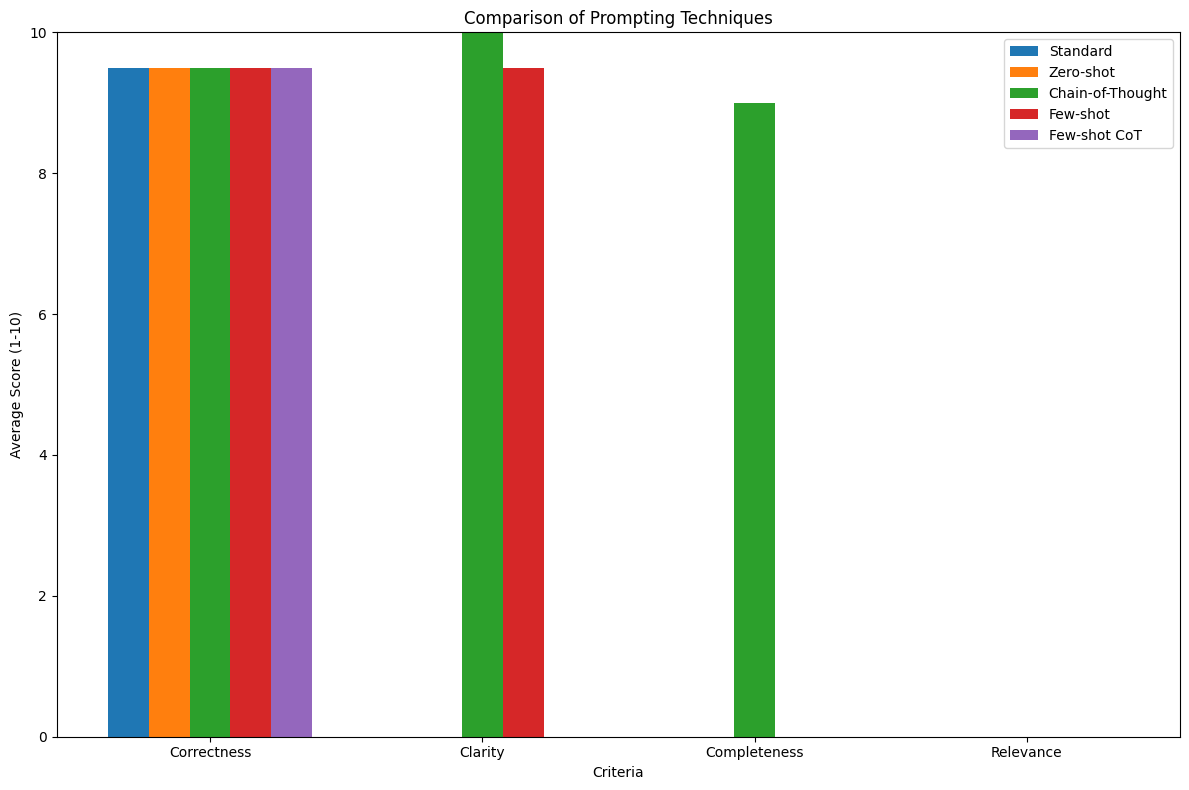

In [23]:
# Suppose `evaluation_results` is a list of results with the key structure:
# {'metrics': {'llm_evaluation': "Standard: 8/10, Clarity: 7/10, ..." }}

plot_evaluation_results(evaluation_results)
